Is CUDA supported by this system? True
CUDA version: 11.6
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA GeForce RTX 2070


100%|██████████| 20/20 [00:24<00:00,  1.22s/it]


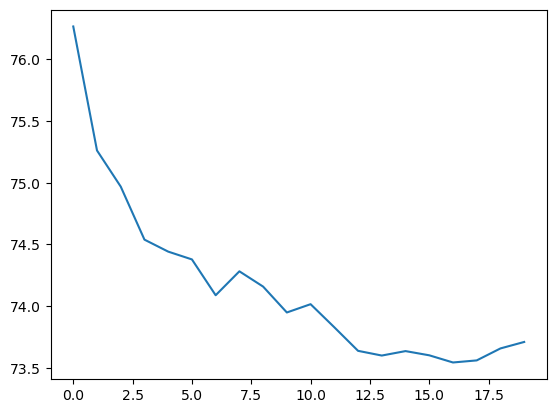

In [1]:
import torch.nn as nn
import torch.optim as optim
from model.dataset import get_dataloaders

import matplotlib.pyplot as plt

from model import FederatedCNN


SRC_PATH = "./resources/pneumoniamnist.npz"


model = FederatedCNN(in_channels=1, num_classes=1)

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.7)
ce_loss = nn.CrossEntropyLoss()

train_dl, test_dl = get_dataloaders(SRC_PATH)

train_loss, test_loss = model.train_model(
    epochs=20,
    optimizer=optimizer,
    criterion=ce_loss,
    train_loader=train_dl,
    test_loader=test_dl
)

plt.plot(train_loss)


Is CUDA supported by this system? True
CUDA version: 11.6
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA GeForce RTX 2070


  0%|          | 0/20 [00:11<?, ?it/s]


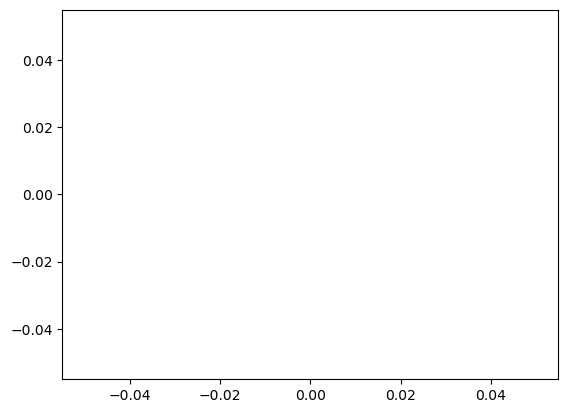